In [1]:
import getpass
import re
import itertools

import sqlalchemy
import pandas as pd

from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_palette("bright")
sns.set_theme()

In [3]:
def ConnectDataBase() -> sqlalchemy.create_engine:
    
    username = input("User postgres:")
    host = input("Host:")
    database = input("Database:")
    password = getpass.getpass("Password:")

    engine = sqlalchemy.create_engine(f'postgresql://{username}:{password}@{host}/{database}')
    return engine

def CreateWordCloud(text:str, stop_words:iter):
    
    wordcloud = WordCloud(width = 1080, height = 720,
                stopwords = stop_words,
                background_color="white",
                min_font_size = 10).generate(text)
    
    return wordcloud

In [4]:
engine = ConnectDataBase()

User postgres: postgres
Host: localhost
Database: youtube
Password: ········


In [5]:
query = "SELECT c.comment, c.published_date, c.likes, u.name, t.title FROM comments AS c \
            LEFT JOIN users AS u ON c.id_user=u.id_user \
            LEFT JOIN titles AS t ON c.id_video=t.id_video \
            LEFT JOIN languages AS l on c.id_language=l.id_language \
        WHERE l.code = 'en'"

comments_df = pd.read_sql(query, engine)
engine.dispose()

In [6]:
comments_df.head()

,comment,published_date,likes,name,title
0,Head over to our shop to get exclusive kurzges...,2019-02-08,3292,Kurzgesagt – In a Nutshell,What Happened Before History? Human Origins
1,"6 different types of humans, that's wild,mind ...",2023-05-21,0,JET LIFE,What Happened Before History? Human Origins
2,You think primitive human woman wore bikinis t...,2023-05-20,0,bob hope,What Happened Before History? Human Origins
3,"i wish we never had left the caves, humans are...",2023-05-20,0,Rafael Olegário,What Happened Before History? Human Origins
4,This together with the clip on kardashev scale...,2023-05-19,0,Roxy,What Happened Before History? Human Origins


In [7]:
comments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138679 entries, 0 to 138678
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   comment         138679 non-null  object
 1   published_date  138679 non-null  object
 2   likes           138679 non-null  int64 
 3   name            138679 non-null  object
 4   title           138679 non-null  object
dtypes: int64(1), object(4)
memory usage: 5.3+ MB


In [8]:
comments_df["published_date"] = pd.to_datetime(comments_df["published_date"], format="%Y-%m-%d")
comments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138679 entries, 0 to 138678
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   comment         138679 non-null  object        
 1   published_date  138679 non-null  datetime64[ns]
 2   likes           138679 non-null  int64         
 3   name            138679 non-null  object        
 4   title           138679 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 5.3+ MB


## EDA

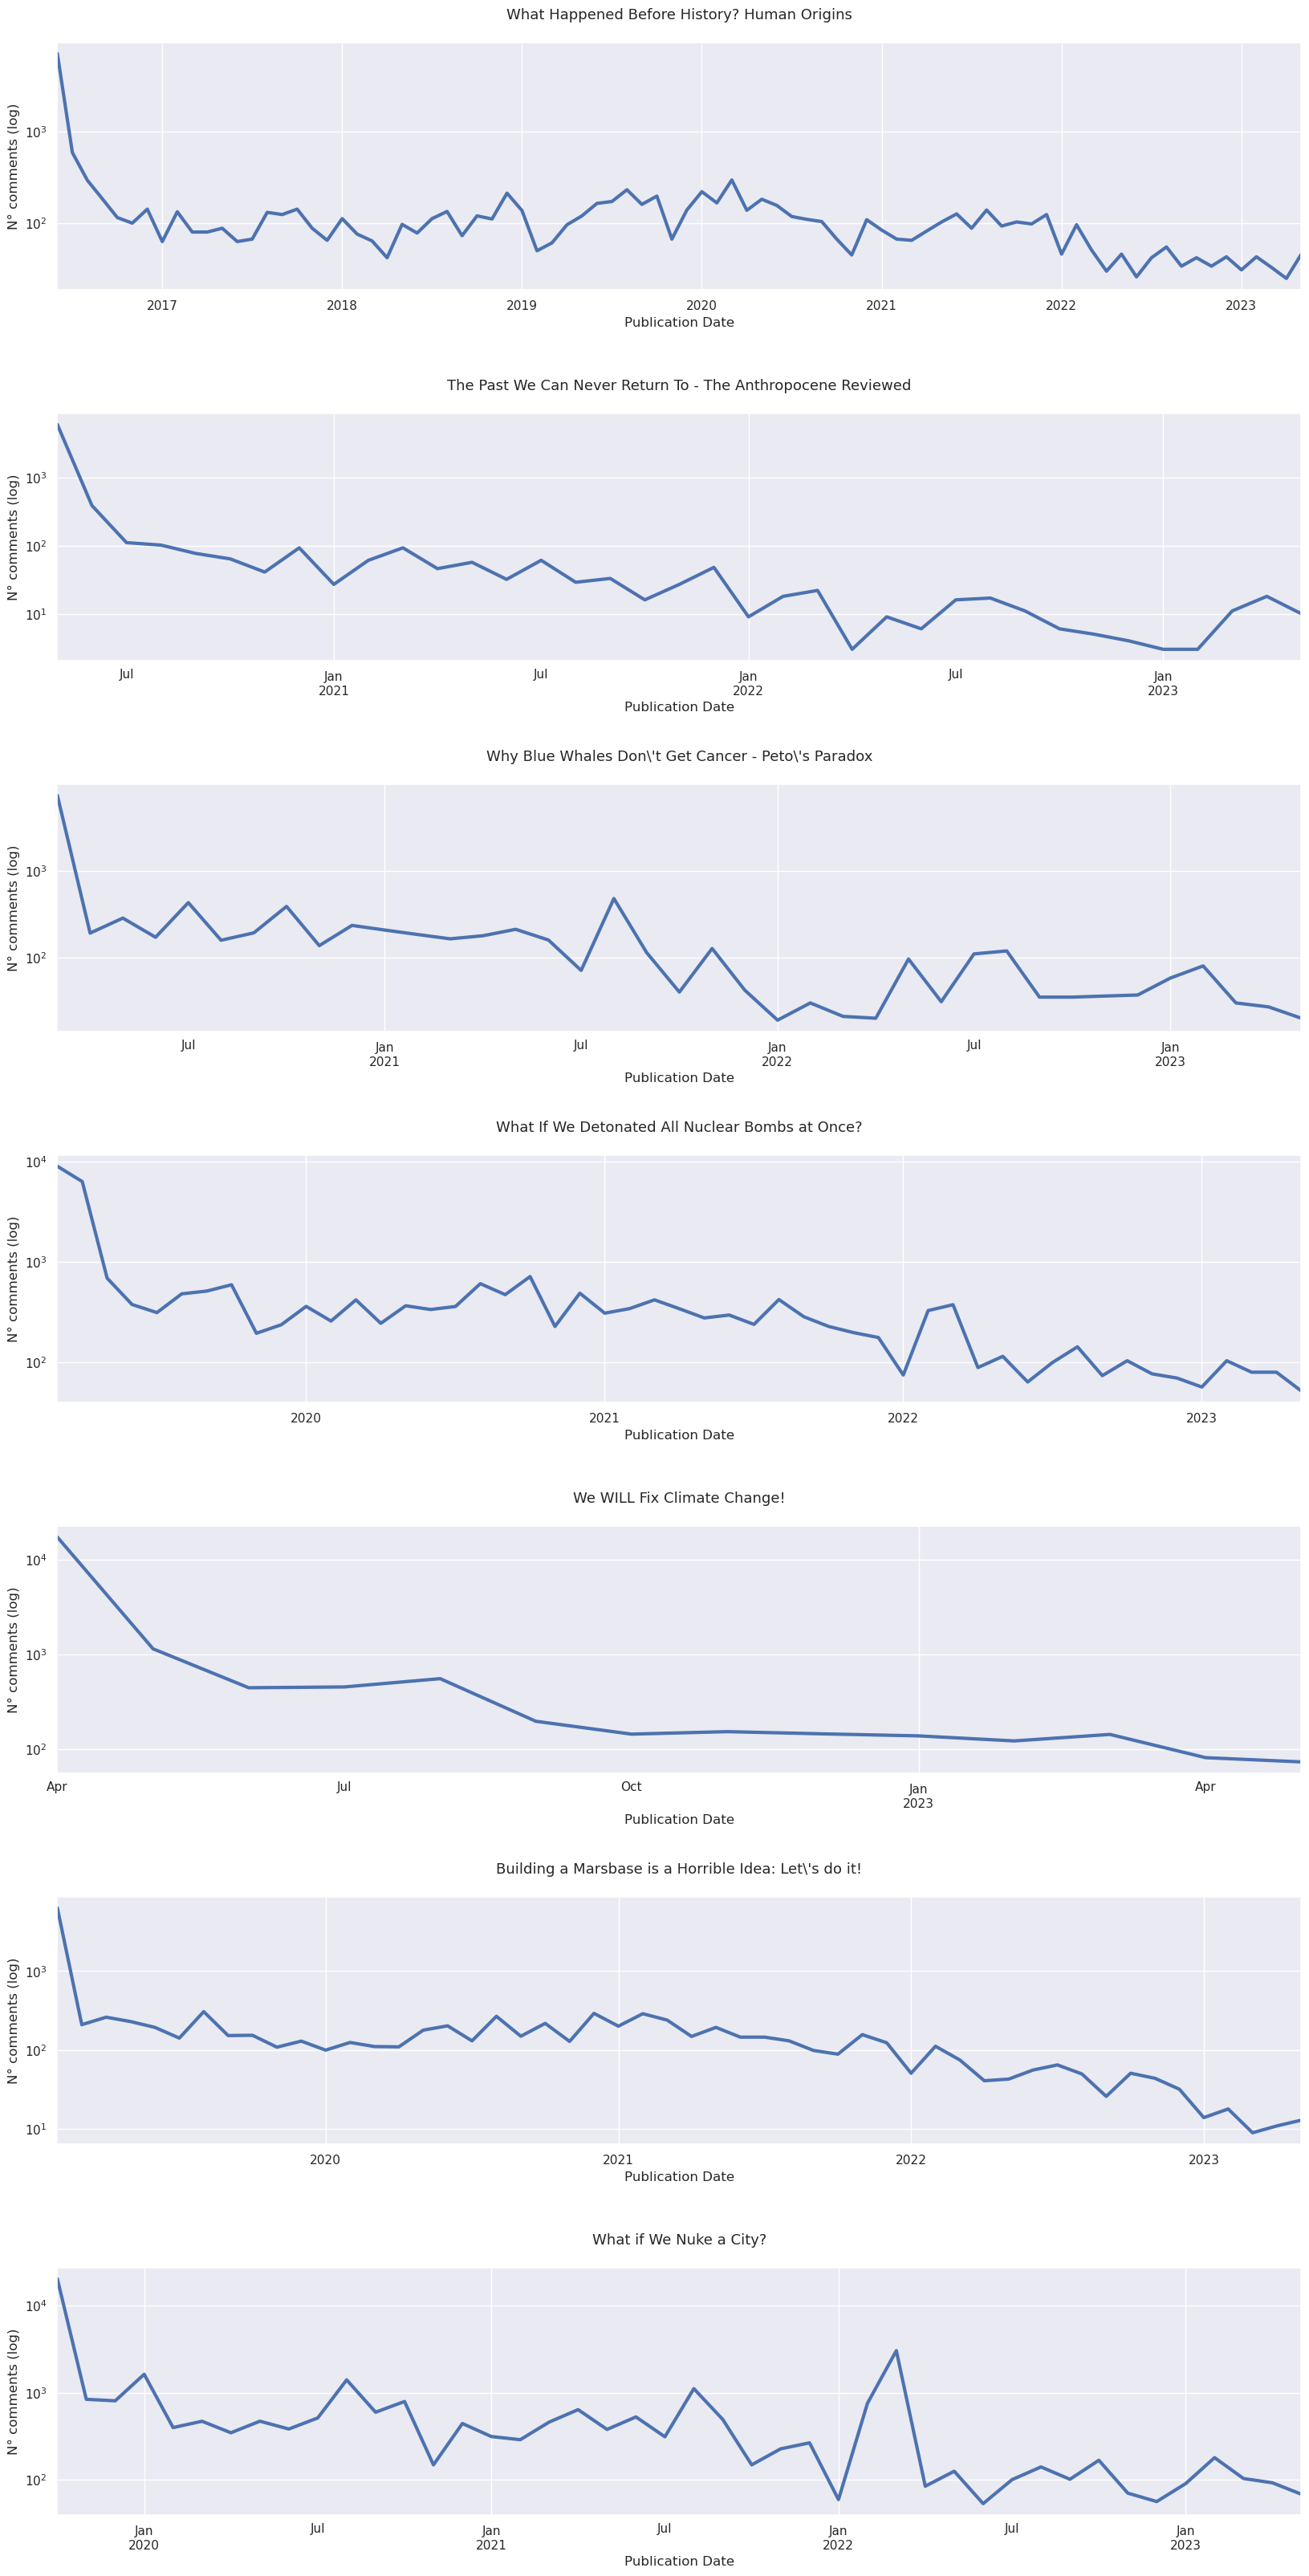

In [9]:
videos = comments_df.title.unique()

fig, axis = plt.subplots(videos.shape[0], 1, figsize=(20, 40))

for video_title, ax in zip(videos, axis):

    video_title = video_title.replace("'","\\'")
    video_title = video_title.replace('"', '\\"')
    
    metrics_video = comments_df.query(f"title == '{video_title}'")
    interactions_by_date = metrics_video[["published_date", "comment"]].resample("m", on="published_date")
    interactions_by_date = interactions_by_date.count()
    
    interactions_by_date.plot.line(ax=ax, logy=True, legend=False, linewidth=3)
    
    ax.set_xlabel("Publication Date")
    ax.set_ylabel("N° comments (log)")
    
    ax.set_title(video_title + "\n", fontdict={"size":13})
    
fig.subplots_adjust(hspace=0.5)
plt.show()

In [10]:
blues_cm = sns.color_palette("Blues", as_cmap=True)

popular_videos_by_comments = comments_df[["comment","title"]]
popular_videos_by_comments = popular_videos_by_comments.groupby("title").count()
popular_videos_by_comments = popular_videos_by_comments.sort_values(by="comment",
                                                                    ascending=False)

popular_videos_by_comments.rename({"comment":"N° comments"},
                                  axis=1, inplace=True)

popular_videos_by_comments.index.rename("Video title", inplace=True)
popular_videos_by_comments.style.background_gradient(cmap=blues_cm)

,N° comments
Video title,
What if We Nuke a City?,40006
What If We Detonated All Nuclear Bombs at Once?,28963
We WILL Fix Climate Change!,20948
What Happened Before History? Human Origins,15977
Building a Marsbase is a Horrible Idea: Let's do it!,12872
Why Blue Whales Don't Get Cancer - Peto's Paradox,12297
The Past We Can Never Return To - The Anthropocene Reviewed,7616


In [11]:
def ApplyStyleMultiIndex(df, cmap, target_column):
    
    df = pd.DataFrame(df)
    style_df = pd.DataFrame(index=df.index,columns=df.columns)
    pattern_background_color = re.compile(r"(background-color#\w+)+")
    pattern_text_color = re.compile(r"\\(color#\w+)+")
    
    for index, group in df.groupby(level=0):
        
        group = pd.DataFrame(group).style.background_gradient(cmap=blues_cm)
        latex_group = group.to_latex()
        
        colors_background = pattern_background_color.findall(latex_group)
        colors_text = pattern_text_color.findall(latex_group)
        
        colors_background = [c.replace("#",": #") for c in colors_background]
        colors_text = [c.replace("#",": #") for c in colors_text]
        
        colors = [ct + ";" + cb for ct, cb in zip(colors_text, colors_background)]
        
        style_df.loc[group.index, target_column] = colors
        
    return style_df

In [12]:
# Top 5 by videos

most_active_users_by_video = comments_df[["name","comment","title"]].groupby(["title","name"])
most_active_users_by_video = most_active_users_by_video.count()

most_active_users_by_video = most_active_users_by_video["comment"].groupby("title",
                                                                           group_keys=False)
most_active_users_by_video = most_active_users_by_video.nlargest(5)

most_active_users_by_video.index.rename(["Video title","User name"], inplace=True)

most_active_users_by_video = pd.DataFrame(most_active_users_by_video)
most_active_users_by_video.rename({"comment":"Comment"}, axis=1, inplace=True)

most_active_users_by_video.style.apply(ApplyStyleMultiIndex,
                                       axis=None,
                                       **{"cmap": blues_cm, "target_column":"Comment"})

In [13]:
# Top 10 most active users
most_active_users_by_channel = comments_df[["name","comment"]].groupby("name").count()
most_active_users_by_channel = most_active_users_by_channel.sort_values("comment", 
                                                                         ascending=False)

most_active_users_by_channel.rename({"comment":"N° comments"},
                                  axis=1, inplace=True)

most_active_users_by_channel.index.rename("User name", inplace=True)

most_active_users_by_channel.iloc[0:10].style.background_gradient(cmap=blues_cm)

,N° comments
User name,
Anh Nguyen Hong,290
der Preusse,61
Caroline Collett,55
Alex,51
Sam,42
J,41
TheYafaShow,35
David,33
Daniel,30


In [14]:
# Comment_most_likes_by_video
comment_most_likes_by_video = comments_df[["title", "name", "comment", "likes"]].copy()

comment_most_likes_by_video.rename({"title":"Video title",
                                    "name":"User name",
                                    "comment":"Comment",
                                    "likes":"N° likes"}, axis=1, inplace=True)

comment_most_likes_by_video = comment_most_likes_by_video.groupby(["Video title",
                                                                   "User name",
                                                                   "Comment"])

comment_most_likes_by_video = comment_most_likes_by_video.sum()

comment_most_likes_by_video = comment_most_likes_by_video["N° likes"].groupby("Video title",
                                                                           group_keys=False)

comment_most_likes_by_video = pd.DataFrame(comment_most_likes_by_video.nlargest(5))
comment_most_likes_by_video.style.apply(ApplyStyleMultiIndex,
                                       axis=None,
                                       **{"cmap": blues_cm, "target_column":"N° likes"})

In [15]:
# Top 10
comment_most_likes_by_channel = comments_df[["comment","likes","name",
                                             "title", "published_date"]]

comment_most_likes_by_channel = comment_most_likes_by_channel.sort_values(by="likes",
                                                                          ascending=False)

comment_most_likes_by_channel.rename({"comment":"Comment",
                                    "likes":"Likes",
                                    "name":"User name",
                                    "title":"Video title",
                                    "published_date":"Publication date"}, axis=1, inplace=True)

comment_most_likes_by_channel = comment_most_likes_by_channel.set_index(["Comment",
                                                                         "User name",
                                                                         "Video title",
                                                                        "Publication date"])

comment_most_likes_by_channel.iloc[0:10].style.background_gradient(cmap=blues_cm)

,,,,Likes
Comment,User name,Video title,Publication date,
"Id like to take a moment to thank Stanislov Petrov, the soviet lieutenant who refused to launch nukes during the cold war when ordered to do so",WiseOldBill,What if We Nuke a City?,2019-10-14 00:00:00,66617
"""It's dire, but not hopeless"" I think is a good mindset for most serious problems in life",The Click,We WILL Fix Climate Change!,2022-04-05 00:00:00,65473
"""Eliminating all nuclear weapons an vowing to never build it again""Countries to each other: After you",Ren Ren,What if We Nuke a City?,2019-10-13 00:00:00,55353
"Basically, being immediately evaporated is the best case",Face Fish,What if We Nuke a City?,2020-05-12 00:00:00,49506
"As you may have noticed, we like to blow stuff up on this channel. So when the International Red Cross approached us to collaborate on a video about nuclear weapons, we were more than excited. Until we did the research. It turned out we were a bit oblivious off the real impact of nuclear weapons in the real world, on a real city. And especially, how helpless even the most developed nations on earth would be if an attack occurred today.This collaboration was a blast (no pun intended) and we want to say a huge thank you to the International Red Cross! Please check out https://www.notonukes.org to learn more about nuclear weapons and what you can do to stop them.",Kurzgesagt – In a Nutshell,What if We Nuke a City?,2019-10-11 00:00:00,38635
That's a pretty intense gender reveal,Royal Pain,What If We Detonated All Nuclear Bombs at Once?,2021-02-01 00:00:00,38130
"""cancer is killing cancer""isn't that just your average League of Legends ranked games?",Hiraeth Neko-chan,Why Blue Whales Don't Get Cancer - Peto's Paradox,2020-03-01 00:00:00,37920
coming back to these nuke videos doesn't seem so fun anymore,marcos vinicius,What if We Nuke a City?,2022-02-27 00:00:00,36503
Can we show some respect for these animators? The quality of their work is amazing!,Bepske Kaatje,What If We Detonated All Nuclear Bombs at Once?,2019-03-31 00:00:00,31626


In [16]:
def RemoveStopWords(sentence:str) -> str:
    return re.sub(fr"\b(?:{'|'.join(stop_words)})\b", " ", sentence)

stop_words_word = set(STOPWORDS)
stop_words_nltk = set(stopwords.words("english"))

stop_words = stop_words_word.union(stop_words_nltk)

comments_normalized = comments_df.comment.str.lower().str.replace('"',"'")
comments_as_string = " ".join(comments_normalized)

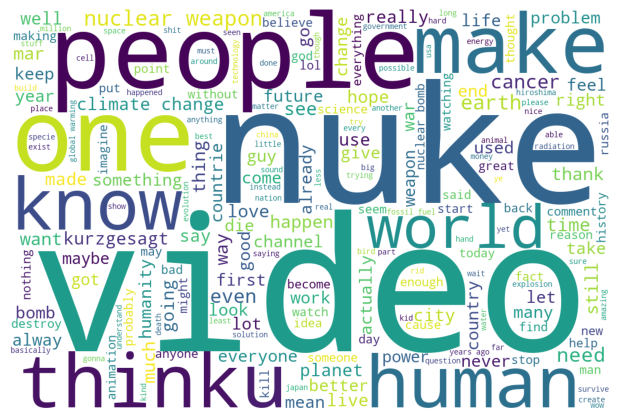

In [17]:
cloud = CreateWordCloud(comments_as_string, stop_words)

plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(cloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

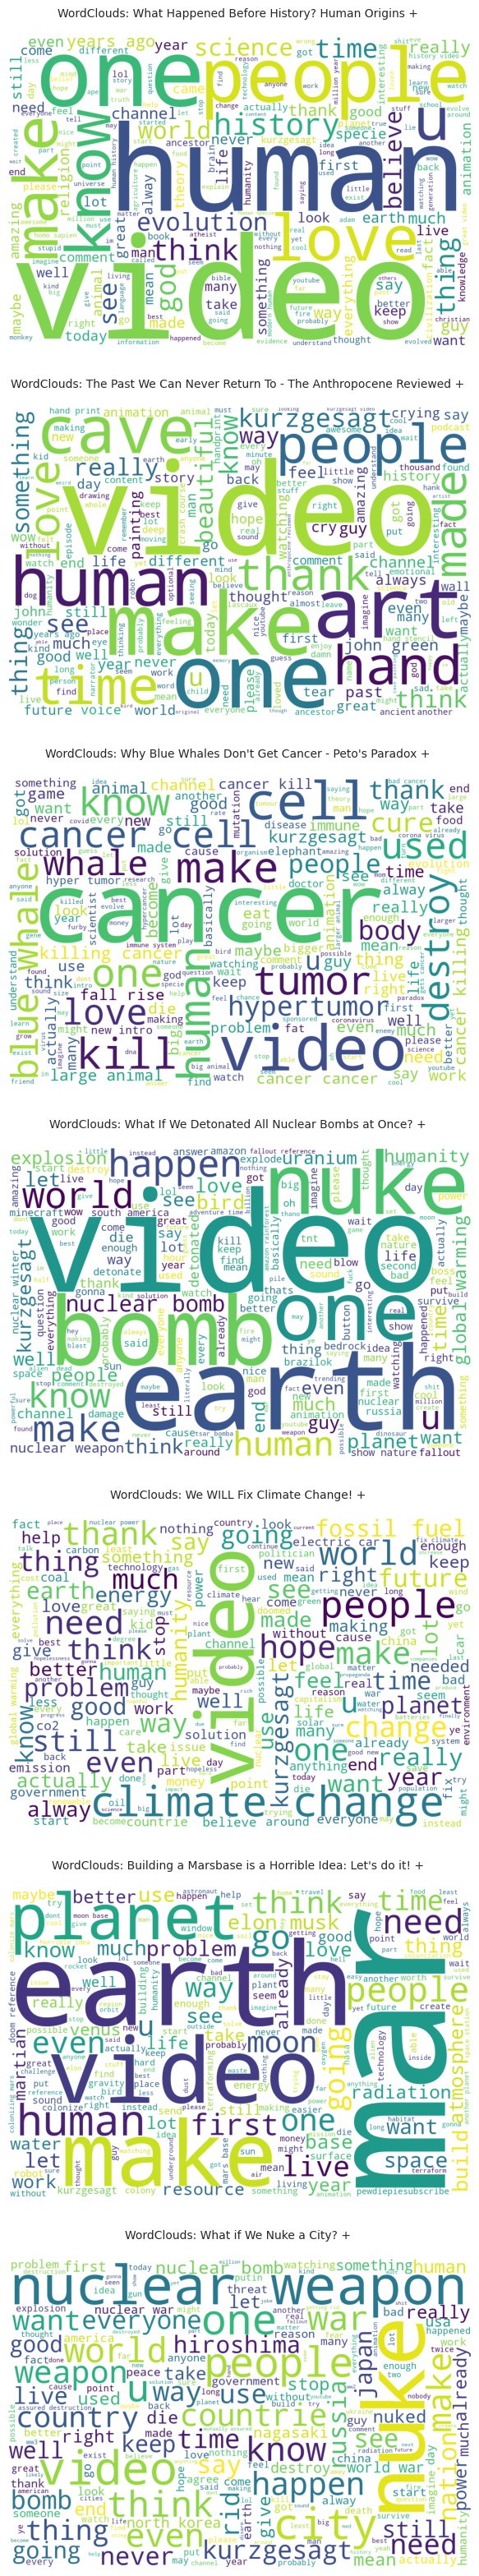

In [18]:
comments_normalized_df = pd.DataFrame({"comments":comments_normalized.to_list()},
                                      index=comments_df["title"])

fig, axis = plt.subplots(len(videos), 1, figsize=(30,40))

for video_title, ax in zip(videos, axis):
    video_comments = comments_normalized_df.loc[video_title]["comments"]
    video_comments_as_string = " ".join(video_comments)
    
    cloud = CreateWordCloud(video_comments_as_string, stop_words)
    ax.imshow(cloud)
    ax.axis("off")
    ax.set_title(f"WordClouds: {video_title} + \n", fontdict={"size":10})
    
fig.subplots_adjust(hspace=0.2)

In [19]:
%%time

def RemoveStopWords(sentence:str) -> str:
    return re.sub(fr"\b(?:{'|'.join(stop_words)})\b", " ", sentence)

def GetContextWords(sentence_tokens:list, context_len:int = 2) -> list:
    
    context_tokens, max_index, context_words = [], len(sentence_tokens) - 1, context_len

    for index, token in enumerate(sentence_tokens):
        
        if token.find("video") > -1:
        
            start_left = 0 if (index - context_words) < 0 else (index - context_words)
            left_context = sentence_tokens[start_left:index]
        
            try:
                righ_context = sentence_tokens[index + 1:index + context_words + 1]
            except:
                righ_context = []
            
            context_tokens.extend(left_context + righ_context)
    
    return context_tokens

print("Filtering comments with 'video' words")
comments_related_video = list(filter(lambda x: x.find("video") > -1, comments_normalized))
comments_related_video = pd.Series(comments_related_video)

print("Removing stop words...")
comments_clean = comments_related_video.apply(RemoveStopWords)

print("Tokenizing...")
tokens_per_comments = comments_clean.apply(word_tokenize)
print("Done")

# Two tokens two to the left and two to the right of the "video" word
print("Getting tokens (context) of the word 'video'")
context_len = 3
context_video_tokens = tokens_per_comments.apply(GetContextWords, context_len = context_len)

context_video_tokens = list(itertools.chain.from_iterable(context_video_tokens))
context_string = " ".join(context_video_tokens)

Filtering comments with 'video' words
Removing stop words...
Tokenizing...
Done
Getting tokens (context) of the word 'video'
CPU times: user 6.18 s, sys: 11.7 ms, total: 6.19 s
Wall time: 6.2 s


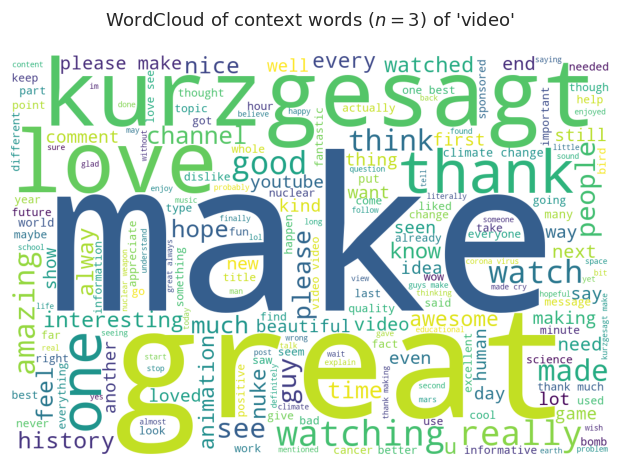

In [20]:
cloud = CreateWordCloud(context_string, stop_words)

plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(cloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.title(f"WordCloud of context words ($n={context_len}$) of 'video'\n", fontdict={"size":13})

plt.show()

## Sentiment analysis